## Validation of model_predict_qubit_TransmonCross_cap_matrix wtih Ansys HFSS

In [1]:
from squadds import SQuADDS_DB
import pandas as pd
from squadds import Analyzer
import matplotlib.pyplot as plt

In [2]:
db = SQuADDS_DB()
db.select_system("qubit")
db.select_qubit("TransmonCross")
df = db.create_system_df()

We don't actually care about using SQuADDS to get a device at the moment, I just use the code block below to get a "template" of the SQUaDDS style dataframe.

In [3]:
analyzer = Analyzer(db)

# we are not actually looking for this Hamiltonian parameters... 
target_params={"qubit_frequency_GHz": 4, "anharmonicity_MHz": -200}

results = analyzer.find_closest(target_params=target_params,
                                       num_top=3,
                                       metric="Euclidean",
                                       display=True)

results = results.head(1) # we'll use this as our template frame we will overwrite!
results.index = [0]

In [4]:
pred_df = results.copy(deep=True)
ref_df = results.copy(deep=True)

## read in ML results

In [5]:
sample = 1 # choose sample from results we to simulate / analysze results from

In [6]:
df_unscaled = pd.read_csv("predictions_and_errors_unscaled_one_hot.csv")

## Map ML outputs to be "SQuADDS" ready
* includes remapping numerical values from one-hot encoding back to their original categorical types

In [7]:
# for now take absolute value of device parameters that cannot be negative
def sim_ready(df_unscaled,type,sample):
    
    if type == 0:
        ref_or_pred = "ref_unscaled"
    elif type == 1:
        ref_or_pred = "pred_unscaled"
    else:
        ref_or_pred = "ref_unscaled"
        print("defaulting to pred_unscaled, valid input for type is 0 for red_unscaled or 1 for pred_unscaled")
        

    design_options_dict = {'aedt_hfss_capacitance':"",
     'aedt_hfss_inductance':"",
     'aedt_q3d_capacitance':"",
     'aedt_q3d_inductance':"",
     'chip': '',
     'connection_pads': {'readout': {'claw_cpw_length': '',
       'claw_cpw_width': '',
       'claw_gap': '',
       'claw_length': '',
       'claw_width': '',
       'connector_location': '',
       'connector_type': '',
       'ground_spacing': ''}},
     'cross_gap': '',
     'cross_length': '',
     'cross_width': '',
     'gds_cell_name': '',
     'hfss_capacitance': '',
     'hfss_inductance': '',
     'hfss_mesh_kw_jj': '',
     'hfss_resistance': '',
     'layer': '',
     'orientation': '',
     'pos_x': '',
     'pos_y': '',
     'q3d_capacitance':'' ,
     'q3d_inductance': '',
     'q3d_mesh_kw_jj': '',
     'q3d_resistance': ''}


    df_unscaled_one_design = df_unscaled[df_unscaled.sample_idx == sample]

    cap_matrix = df_unscaled_one_design[["cross_to_ground","claw_to_ground","cross_to_claw","cross_to_cross","claw_to_claw","ground_to_ground"]].iloc[0].to_dict()
    
    remapping = ["chip","gds_cell_name"]
    params_um = ["cross_gap","cross_length","cross_width","pos_x","pos_y"]
    params_nH = ["q3d_inductance"]


    design_options = {}
    
    for option,value in zip(df_unscaled_one_design["param"],df_unscaled_one_design[ref_or_pred]):
    
        options = option.split(".")
        
        if options[1] == "connection_pads":
            if options[3] == 'connector_location' or options[3] == 'connector_type':
                design_options_dict[options[1]][options[2]][options[3]] = round(value)
            else:
                design_options_dict[options[1]][options[2]][options[3]] = str(value * 10**6)+"um"
    
        elif options[1] in params_um:
            design_options_dict[options[1]] = str(value * 10**6)+"um"
    
        elif options[1] in params_nH:
            design_options_dict[options[1]] = str(value * 10**9)+"nH"
    
        elif options[1] == "chip_main":
            design_options_dict["chip"] = "main"
            
        elif options[1] == "gds_cell_name_my_other_junction":
            design_options_dict["gds_cell_name"] = "my_other_junction"
    
        elif options[1] == 'layer' or options[1] == 'orientation':
            design_options_dict[options[1]] = round(value)

        else:
            design_options_dict[options[1]] = value
    
    return design_options_dict,cap_matrix

## grab predicted and reference device from a given sample

In [8]:
ref_do,ref_cm = sim_ready(df_unscaled,0,sample)
pred_do,pred_cm = sim_ready(df_unscaled,1,sample)

In [9]:
pred_do_dynamic = pred_do.copy()

### temporary fix while we debug ML model
* the ML model has trouble predicting static values, for now we can substitute the known truth values into predicted design

In [10]:
substitute_static_vals = True

# design dictionary containing all static device parameters (e.g., params that don't change in SQuADDS database)
static_params = {'pos_x': '-1500um',
  'pos_y': '1200um',
  'orientation': '-90',
  'chip': 'main',
  'layer': '1',
  'connection_pads': {'readout': {
    'connector_type': '0',
    'claw_width': '15um',
    'claw_gap': '5.1um',
    'claw_cpw_length': '40um',
    'claw_cpw_width': '10um',
    'connector_location': '90'}},
  'cross_width': '30um',
  'cross_gap': '30um',
  'hfss_inductance': 9.686e-09,
  'hfss_capacitance': 0,
  'hfss_resistance': 0,
  'hfss_mesh_kw_jj': 7e-06,
  'q3d_inductance': '10nH',
  'q3d_capacitance': 0,
  'q3d_resistance': 0,
  'q3d_mesh_kw_jj': 7e-06,
  'gds_cell_name': 'my_other_junction',
  'aedt_q3d_inductance': 1e-08,
  'aedt_q3d_capacitance': 0,
  'aedt_hfss_inductance': 9.686e-09,
  'aedt_hfss_capacitance': 0}


if substitute_static_vals == True:
    for stat_key in static_params:
        if stat_key == 'connection_pads':
            pass
        else:
            pred_do[stat_key] = static_params[stat_key]

    pred_do['connection_pads']['readout']['connector_type'] = static_params['connection_pads']['readout']['connector_type']
    pred_do['connection_pads']['readout']['claw_width'] = static_params['connection_pads']['readout']['claw_width']
    pred_do['connection_pads']['readout']['claw_gap'] = static_params['connection_pads']['readout']['claw_gap']
    pred_do['connection_pads']['readout']['claw_cpw_length'] = static_params['connection_pads']['readout']['claw_cpw_length']
    pred_do['connection_pads']['readout']['claw_cpw_width'] = static_params['connection_pads']['readout']['claw_cpw_width']
    pred_do['connection_pads']['readout']['connector_location'] = static_params['connection_pads']['readout']['connector_location']

add device parameters to ref and pred dataframes - we're now ready to simulate

In [11]:
ref_df.at[0, "design_options"] = ref_do
ref_df.cross_to_ground.iloc[0] = ref_cm["cross_to_ground"] # we dont actually need the new cap matrix info but I added it anyway
ref_df.claw_to_ground.iloc[0] = ref_cm["claw_to_ground"]
ref_df.cross_to_claw.iloc[0] = ref_cm["cross_to_claw"]
ref_df.cross_to_cross.iloc[0] = ref_cm["cross_to_cross"]
ref_df.claw_to_claw.iloc[0] = ref_cm["claw_to_claw"]
ref_df.ground_to_ground.iloc[0] = ref_cm["ground_to_ground"]

pred_df.at[0, "design_options"] = pred_do
pred_df.cross_to_ground.iloc[0] = pred_cm["cross_to_ground"]
pred_df.claw_to_ground.iloc[0] = pred_cm["claw_to_ground"]
pred_df.cross_to_claw.iloc[0] = pred_cm["cross_to_claw"]
pred_df.cross_to_cross.iloc[0] = pred_cm["cross_to_cross"]
pred_df.claw_to_claw.iloc[0] = pred_cm["claw_to_claw"]
pred_df.ground_to_ground.iloc[0] = pred_cm["ground_to_ground"]

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 C:\Users\firas\AppData\Local\Temp\17\ipykernel_25800\3663669858.py: 2
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 C:\Users\firas\AppData\Local\Temp\17\ipykernel_25800\3663669858.py: 3
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 C:\Users\firas\AppData\Local\Temp\17\ipykernel_25800\3663669858.py: 4
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing

In [12]:
ref_device = ref_df.iloc[0]
pred_device = pred_df.iloc[0]

## Simualte ML predicted design with Ansys HFSS

In [13]:
from squadds import AnsysSimulator

### Simulate reference device

In [14]:
ref_ansys_simulator = AnsysSimulator(analyzer, ref_device)

selected system: qubit


In [15]:
ref_ansys_results = ref_ansys_simulator.simulate(ref_device)

INFO 11:51AM [connect_project]: Connecting to Ansys Desktop API...
INFO 11:51AM [load_ansys_project]: 	Opened Ansys App
INFO 11:51AM [load_ansys_project]: 	Opened Ansys Desktop v2023.2.0
INFO 11:51AM [load_ansys_project]: 	Opened Ansys Project
	Folder:    C:/Users/firas/Documents/Ansoft/
	Project:   Project3
INFO 11:51AM [connect_design]: 	Opened active design
	Design:    LOMv2.0_q3d3 [Solution type: Q3D]
INFO 11:51AM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 11:51AM [connect]: 	Connected to project "Project3" and design "LOMv2.0_q3d3" 😀 



the parameters ['run'] are unsupported, so they have been ignored


INFO 11:51AM [connect_design]: 	Opened active design
	Design:    LOMv2.0_q3d4 [Solution type: Q3D]
WARNING 11:51AM [connect_setup]: 	No design setup detected.
WARNING 11:51AM [connect_setup]: 	Creating Q3D default setup.
INFO 11:51AM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 11:51AM [get_setup]: 	Opened setup `sweep_setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 11:51AM [analyze]: Analyzing setup sweep_setup
INFO 11:52AM [get_matrix]: Exporting matrix data to (C:\Users\firas\AppData\Local\Temp\17\tmp5sv_77dr.txt, C, , sweep_setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 11:52AM [get_matrix]: Exporting matrix data to (C:\Users\firas\AppData\Local\Temp\17\tmpj5rhn32y.txt, C, , sweep_setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 11:52AM [get_matrix]: Exporting matrix data to (C:\Users\firas\AppData\Local\Temp\17\tmp2qeavao0.txt, C, , sweep_setup:AdaptiveP

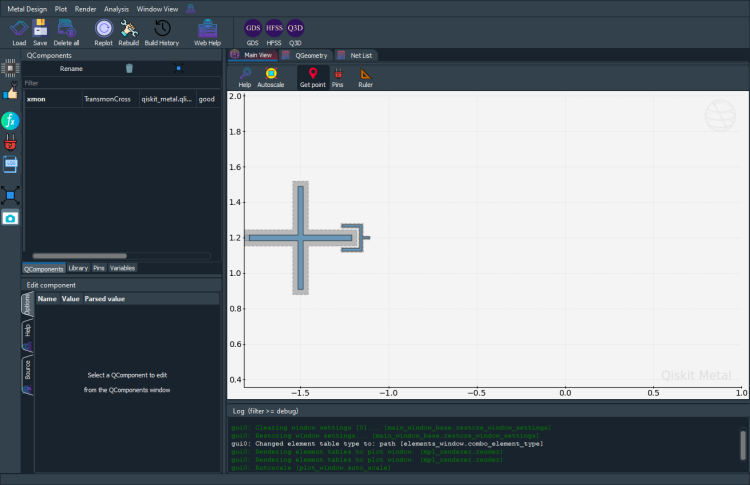

In [16]:
ref_ansys_simulator.get_design_screenshot()

### Simulate predicted device

In [17]:
pred_ansys_simulator = AnsysSimulator(analyzer, pred_device)

selected system: qubit


In [18]:
pred_ansys_results = pred_ansys_simulator.simulate(pred_device)

INFO 11:52AM [connect_project]: Connecting to Ansys Desktop API...
INFO 11:52AM [load_ansys_project]: 	Opened Ansys App
INFO 11:52AM [load_ansys_project]: 	Opened Ansys Desktop v2023.2.0
INFO 11:52AM [load_ansys_project]: 	Opened Ansys Project
	Folder:    C:/Users/firas/Documents/Ansoft/
	Project:   Project3
INFO 11:52AM [connect_design]: 	Opened active design
	Design:    LOMv2.0_q3d4 [Solution type: Q3D]
INFO 11:52AM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 11:52AM [connect]: 	Connected to project "Project3" and design "LOMv2.0_q3d4" 😀 



the parameters ['run'] are unsupported, so they have been ignored


INFO 11:52AM [connect_design]: 	Opened active design
	Design:    LOMv2.0_q3d5 [Solution type: Q3D]
WARNING 11:52AM [connect_setup]: 	No design setup detected.
WARNING 11:52AM [connect_setup]: 	Creating Q3D default setup.
INFO 11:52AM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 11:52AM [get_setup]: 	Opened setup `sweep_setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 11:52AM [analyze]: Analyzing setup sweep_setup
INFO 11:54AM [get_matrix]: Exporting matrix data to (C:\Users\firas\AppData\Local\Temp\17\tmp_hkw2iuy.txt, C, , sweep_setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 11:54AM [get_matrix]: Exporting matrix data to (C:\Users\firas\AppData\Local\Temp\17\tmpbyrj5t10.txt, C, , sweep_setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 11:54AM [get_matrix]: Exporting matrix data to (C:\Users\firas\AppData\Local\Temp\17\tmp6jm05_iw.txt, C, , sweep_setup:AdaptiveP

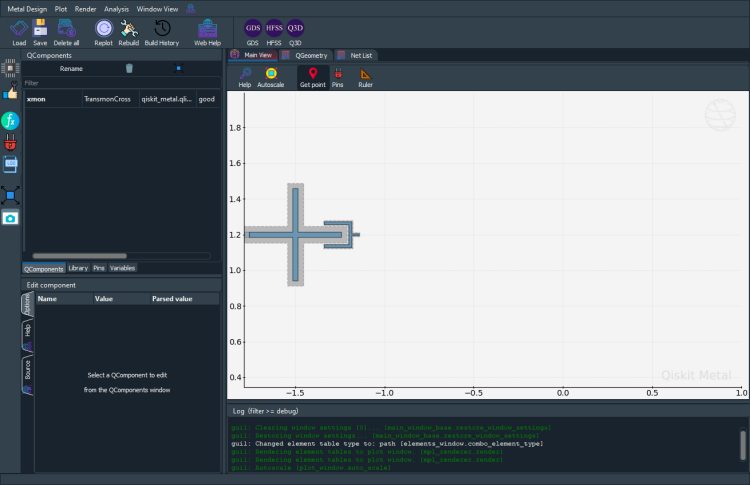

In [19]:
pred_ansys_simulator.get_design_screenshot()

## Benchmarking plots

### percent difference between reference and predicted devices

In [21]:
labels = ["design_options.connection_pads.readout.claw_length",
"design_options.connection_pads.readout.ground_spacing",
"design_options.connection_pads.readout.claw_width",
"design_options.connection_pads.readout.claw_gap",
"design_options.connection_pads.readout.claw_cpw_length",
"design_options.connection_pads.readout.claw_cpw_width",
"design_options.cross_width",
"design_options.cross_length",
"design_options.cross_gap"]


tester = df_unscaled[(df_unscaled["param"].isin(labels)) & (df_unscaled.sample_idx == sample)] # isolate some params
num = abs(abs(tester.ref_unscaled) - abs(tester.pred_unscaled))/(abs(tester.ref_unscaled) + abs(tester.pred_unscaled))/2 * 100

xbar = []
for lab in labels:
    splitter = lab.split(".")
    xbar.append(splitter[len(splitter)-1])

In [22]:
fig,ax = plt.subplots()
plt.bar(xbar,num)
plt.xticks(rotation = 45)
plt.ylabel("Percent Difference [%] between reference & prediction")
plt.title("% differences between ref_unscaled & pred_unscaled \n sample_idx {}".format(sample))
plt.savefig(r"C:\Users\firas\Desktop\percentDiff_sample{}.png".format(sample),bbox_inches='tight')

### comparing capacitance matrices between smulation of predicted & reference devices and the truth input values

In [23]:
ref_cap_matrix = ref_ansys_results["sim_results"]
pred_cap_matrix = pred_ansys_results["sim_results"]
input_cap_matrix = df_unscaled[df_unscaled.sample_idx == sample][["cross_to_ground","claw_to_ground","cross_to_claw","cross_to_cross","claw_to_claw","ground_to_ground"]].iloc[0].to_dict()

In [24]:
fig,ax = plt.subplots()
x = list(ref_cap_matrix.keys())[:-1] # remove units entry
y1 = list(ref_cap_matrix.values())[:-1]
y2 = list(pred_cap_matrix.values())[:-1]
y3 = list(input_cap_matrix.values())

plt.scatter(x,y3,marker = 'x',s = 100,alpha = 0.8,label = "input (x) values")
plt.scatter(x,y1,marker = "v",s = 100,alpha = 0.8,label = "simulation results of reference")
plt.scatter(x,y2,s = 100,marker = '+',label = "simulation results of prediction")
plt.xticks(rotation = 45)
plt.title("Capacitance matrix Comparsions \n sample_idx {}".format(sample))
plt.ylabel("Capacitance [pF]")
plt.savefig(r"C:\Users\firas\Desktop\capMatrixCompare_sample{}.png".format(sample),bbox_inches='tight')

In [25]:
analysis_dict = {"ref_cap":[],"pred_cap":[],"x_cap":[],"ref_design":[],"static_pred_design":[],"pred_design":[]}

In [26]:
analysis_dict["ref_cap"] += [ref_cap_matrix]
analysis_dict["pred_cap"] += [pred_cap_matrix]
analysis_dict["x_cap"] += [input_cap_matrix]
analysis_dict["ref_design"] += [ref_do]
analysis_dict["static_pred_design"] += [pred_do]
analysis_dict["pred_design"] += [pred_do_dynamic]

In [27]:
analysis_frame = pd.DataFrame(analysis_dict)
analysis_frame.to_csv("results_sample{}.csv".format(sample))

In [28]:
analysis_frame

,ref_cap,pred_cap,x_cap,ref_design,static_pred_design,pred_design
0,"{'cross_to_ground': 154.28754, 'claw_to_ground...","{'cross_to_ground': 134.73588, 'claw_to_ground...","{'cross_to_ground': 148.829, 'claw_to_ground':...","{'aedt_hfss_capacitance': 0.0, 'aedt_hfss_indu...","{'aedt_hfss_capacitance': 0, 'aedt_hfss_induct...","{'aedt_hfss_capacitance': 0.000860194, 'aedt_h..."
